# Data

In [1]:
import pandas as pd

train_path = "./../data/train.csv"
test_path = "./../data/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("\nTrain head:")
print(train_df.head())

print("\nTest head:")
print(test_df.head())

Train shape: (10000, 2)
Test shape: (2000, 2)

Train head:
                                               input  \
0               reconciliation trolls realized scene   
1                        scratched kemp blah devices   
2  delusional engineered perfect prey englishman ...   
3  boomers nfl reacts parallels everything 6 redu...   
4  patience put christmas superhero luc rake fulf...   

                                              target  
0               enecs dezilaer sllort noitailicnocer  
1                        secived halb pmek dehctarcs  
2  hctarcs detsub namhsilgne yerp tcefrep dereeni...  
3  stcudnoc ysereh redlof secuder 6 gnihtyreve sl...  
4  ylesned ylno elbats latnenitnoc dellifluf ekar...  

Test head:
                                               input  \
0  intimidated campaigns emerging marines spin be...   
1            salary lebanese wifi fury fab sta polly   
2  financing ahmed sexual cinematic puff malibu p...   
3  n00 nickel disparity funded tutoria

# BLT Transformer

In [2]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, falling back to CPU")

✅ Using MPS (Apple Silicon GPU)


## Patcher (entropy-based segmentation)

**Shannon Entropy Function**

Helper to compute entropy of a sequence of characters.

H = - \sum p(x) \cdot \log_2(p(x))

In [3]:
import math
from collections import Counter

def shannon_entropy(text: str) -> float:
    """Compute Shannon entropy of a string."""
    if not text:
        return 0.0
    counts = Counter(text)
    probs = [count / len(text) for count in counts.values()]
    # Handle potential log2(0) case for characters with probability 0 (though Counter avoids this)
    return -sum(p * math.log2(p) for p in probs if p > 0)

**Patcher Function**

- Use sliding window of size W=10.
- Keep adding characters to current patch until either:
    - Entropy > threshold(2.0)
    - Patch length > 15
- Then start a new patch.

In [4]:
def patchify(text: str, window_size=12, entropy_threshold=2.5, max_patch_len=20):
    patches = []
    current_patch = ""
    for ch in text:
        current_patch += ch
        entropy = (
            shannon_entropy(current_patch[-window_size:])
            if len(current_patch) >= window_size else 0
        )
        if entropy > entropy_threshold or len(current_patch) >= max_patch_len:
            # Ensure we don't add empty strings if strip results in nothing
            stripped_patch = current_patch.strip()
            if stripped_patch:
                patches.append(stripped_patch)
            current_patch = "" # Reset even if stripped patch was empty
    # Add leftover patch only if it's not empty after stripping
    stripped_patch = current_patch.strip()
    if stripped_patch:
        patches.append(stripped_patch)
    return patches

**Test Patcher**

In [5]:
sample_texts = [
    "reconciliation trolls realized scene", # High entropy, more splits
    "LMA is fun!", # Based on threshold, may not split
    "aaaaabbbbbcccccddddd"  # low entropy predictable
]

for txt in sample_texts:
    patches = patchify(txt)
    print(f"\nText: {txt}")
    print("Patches:", patches)


Text: reconciliation trolls realized scene
Patches: ['reconciliati', 'on trolls re', 'alized scene']

Text: LMA is fun!
Patches: ['LMA is fun!']

Text: aaaaabbbbbcccccddddd
Patches: ['aaaaabbbbbcccccddddd']


## Hash N-Gram Embeddings

1. Extract all n-grams (n=1,2,3) from each patch.
2. Map each n-gram into a bucket in [0, 4095].
3. Use an embedding lookup table (nn.Embedding) to get a 64-d vector.
4. Sum all vectors → final patch embedding (shape = [64]).

**Hash Function**

In [6]:
import hashlib

def hash_ngram(ngram: str, num_buckets=4096) -> int:
    """Hash an n-gram string into a bucket [0, num_buckets-1]."""
    return int(hashlib.md5(ngram.encode("utf-8")).hexdigest(), 16) % num_buckets

**N-Gram Extraction**

In [7]:
def extract_ngrams(text: str, n: int):
    return [text[i:i+n] for i in range(len(text)-n+1)]

**Patch Embedding Module**

In [8]:
import torch
import torch.nn as nn

class PatchEmbedder(nn.Module):
    def __init__(self, num_buckets=4096, embed_dim=64):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            "1": nn.Embedding(num_buckets, embed_dim),
            "2": nn.Embedding(num_buckets, embed_dim),
            "3": nn.Embedding(num_buckets, embed_dim),
        })
        # Xavier init
        for emb in self.embeddings.values():
            nn.init.xavier_uniform_(emb.weight)

        self.num_buckets = num_buckets
        self.embed_dim = embed_dim

    def forward(self, patch: str):
        """Convert one patch string into a [embed_dim] vector."""
        vectors = []
        # get device from embedding params
        device = next(self.embeddings["1"].parameters()).device  

        for n in [1, 2, 3]:
            ngrams = extract_ngrams(patch, n)
            for ng in ngrams:
                bucket = hash_ngram(ng, self.num_buckets)
                idx = torch.tensor(bucket, dtype=torch.long, device=device)
                vectors.append(self.embeddings[str(n)](idx))

        if len(vectors) == 0:
            return torch.zeros(self.embed_dim, device=device)

        return torch.stack(vectors, dim=0).sum(dim=0)  # sum across n-grams

**Test It on Sample Patches**

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
embedder = PatchEmbedder().to(device)

sample_patches = ["reconcilia", "tion troll", "s realized", " scene"]

print(f"Device: {device}")

for patch in sample_patches:
    vec = embedder(patch)
    print(f"Patch: {patch} | Embedding shape: {vec.shape}")

Device: mps
Patch: reconcilia | Embedding shape: torch.Size([64])
Patch: tion troll | Embedding shape: torch.Size([64])
Patch: s realized | Embedding shape: torch.Size([64])
Patch:  scene | Embedding shape: torch.Size([64])


## BLT Dataset Class

This dataset will:
1. Read train.csv / test.csv.
2. For each row:
    - Take input string → apply patchify → embed patches into [seq_len, 64].
    - Take target string → here we’ll keep it character-level for decoder supervision (simpler than patching the output).
3. Return tensors for (src_seq, tgt_seq).

In [10]:
import torch
from torch.utils.data import Dataset
import pandas as pd

PRINTABLE_ASCII = [chr(i) for i in range(32, 127)]
VOCAB = ['<PAD>', '<SOS>', '<EOS>'] + PRINTABLE_ASCII # PAD=0, SOS=1, EOS=2

# Mapping from character to index
CHAR_TO_IDX = {ch: i for i, ch in enumerate(VOCAB)}
PAD_IDX = CHAR_TO_IDX['<PAD>']
SOS_IDX = CHAR_TO_IDX['<SOS>']
EOS_IDX = CHAR_TO_IDX['<EOS>']


class BLTDataset(Dataset):
    def __init__(self, csv_path, window_size=12, entropy_threshold=2.5, max_patch_len=20):
        self.data = pd.read_csv(csv_path)
        self.window_size = window_size
        self.entropy_threshold = entropy_threshold
        self.max_patch_len = max_patch_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inp, tgt = row["input"], row["target"]

        patches = patchify(inp, 
                            window_size=self.window_size,
                            entropy_threshold=self.entropy_threshold,
                            max_patch_len=self.max_patch_len)

        # The vocabulary mapping
        tgt_ids = [CHAR_TO_IDX.get(c, PAD_IDX) for c in tgt] 
        tgt_tensor = torch.tensor([SOS_IDX] + tgt_ids + [EOS_IDX], dtype=torch.long)

        return patches, tgt_tensor

In [11]:
IDX_TO_CHAR = {i: ch for ch, i in CHAR_TO_IDX.items()}
train_ds = BLTDataset(csv_path="./../data/train.csv")
src_patches, tgt_tensor = train_ds[0]

print("\n1. Source Data (Input):")
print(f"   - Type: {type(src_patches)}")
print(f"   - Number of patches: {len(src_patches)}")
print(f"   - Patches content (first 5): {src_patches[:5]}")

print("\n2. Target Data (Output):")
print(f"   - Type: {type(tgt_tensor)}")
print(f"   - Shape: {tgt_tensor.shape}")
print(f"   - Dtype: {tgt_tensor.dtype}")
print(f"   - Content (first 15 IDs): {tgt_tensor[:15].tolist()}") # .tolist() for clean printing

# 3. Check the reconstruction
reconstructed_string = "".join([IDX_TO_CHAR.get(i.item(), '') for i in tgt_tensor])
print("\n3. Target String Reconstruction:")
print(f"   - Reconstructed: {reconstructed_string}")

original_target = train_df.iloc[0]['target']
print(f"   - Original:      <SOS>{original_target}<EOS>")


1. Source Data (Input):
   - Type: <class 'list'>
   - Number of patches: 3
   - Patches content (first 5): ['reconciliati', 'on trolls re', 'alized scene']

2. Target Data (Output):
   - Type: <class 'torch.Tensor'>
   - Shape: torch.Size([38])
   - Dtype: torch.int64
   - Content (first 15 IDs): [1, 72, 81, 72, 70, 86, 3, 71, 72, 93, 76, 79, 68, 72, 85]

3. Target String Reconstruction:
   - Reconstructed: <SOS>enecs dezilaer sllort noitailicnocer<EOS>
   - Original:      <SOS>enecs dezilaer sllort noitailicnocer<EOS>


## Collate Function for BLT

We’ll:
1. Take a batch of (src_seq, tgt_seq).
2. Pad src_seq to [batch, max_src_len, 64].
3. Pad tgt_seq to [batch, max_tgt_len].
4. Return padded tensors + lengths (useful for masking in the model).

In [12]:
from torch.nn.utils.rnn import pad_sequence

def blt_collate_fn(batch):
    # batch is a list of (patches, tgt_tensor)
    src_patches, tgt_seqs = zip(*batch)

    # Pad target sequences (char IDs)
    tgt_padded = pad_sequence(tgt_seqs, batch_first=True, padding_value=0) # Assuming 0 is PAD_IDX

    # The source patches remain a list of lists of strings
    # e.g., [ ['patch1', 'patch2'], ['p1', 'p2', 'p3'], ... ]
    return list(src_patches), tgt_padded

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_size = int(0.9 * len(train_ds))
val_size   = len(train_ds) - train_size
train_subset, val_subset = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(
    train_subset,
    batch_size=8,
    shuffle=True,
    collate_fn=blt_collate_fn
)

val_loader = DataLoader(
    val_subset,
    batch_size=4,
    shuffle=False,
    collate_fn=blt_collate_fn
)

print("Running Sanity Check on DataLoader")
src_patches_batch, tgt_padded_batch = next(iter(train_loader))

print("\n1. Source Data Batch (Input):")
print(f"   - Type: {type(src_patches_batch)}")
print(f"   - Length (Batch Size): {len(src_patches_batch)}")
print(f"   - Content of first item in batch: {src_patches_batch[0]}")

print("\n2. Target Data Batch (Output):")
print(f"   - Type: {type(tgt_padded_batch)}")
print(f"   - Shape (Batch Size, Max Target Length): {tgt_padded_batch.shape}")

Running Sanity Check on DataLoader

1. Source Data Batch (Input):
   - Type: <class 'list'>
   - Length (Batch Size): 8
   - Content of first item in batch: ['hardened wag', 'on february', 'historically', 'takeaway we', 'ird reimburs', 'ement + bomb', 'ardment berg']

2. Target Data Batch (Output):
   - Type: <class 'torch.Tensor'>
   - Shape (Batch Size, Max Target Length): torch.Size([8, 131])


## BLT Model Architecture

Core Idea:
1. Encoder: Take patch embeddings [B, L, 64], map into hidden dimension with a transformer encoder.
2. Decoder: Generate characters (IDs) step by step using a transformer decoder.
3. Output layer: Linear projection → vocab size.

In [14]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # Note: In our implementation, we use batch_first=True, so the shape is [B, L, D].
        # The stored pe is [max_len, 1, D]. We need to adjust it for batch.
        x = x + self.pe[:x.size(1)].transpose(0, 1) # Transpose to [1, L, D] to broadcast
        return self.dropout(x)

In [15]:
from torch.nn.utils.rnn import pad_sequence

# Assume PatchEmbedder, PositionalEncoding, and helper functions are defined above

class BLTModel(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.patch_embedder = PatchEmbedder(num_buckets=4096, embed_dim=d_model)
        self.global_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.tgt_embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # --- ARCHITECTURE (1-1-2 STRUCTURE) ---
        # 1. ENCODER (1 Block)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4, 
            dropout=dropout, batch_first=True
        )
        # FIX: Added 'enable_nested_tensor=False' for MPS compatibility
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1, enable_nested_tensor=False)

        # 2. GLOBAL TRANSFORMER (2 Blocks)
        global_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True
        )
        # FIX: Added 'enable_nested_tensor=False' for MPS compatibility
        self.global_transformer = nn.TransformerEncoder(global_layer, num_layers=2, enable_nested_tensor=False)

        # 3. DECODER (1 Block)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=1)

        # --- FINAL OUTPUT LAYER ---
        self.norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, src_patches_batch, tgt_inp, tgt_pad_mask=None):
        # src_patches_batch: A list (size B) of lists of patch strings
        # tgt_inp: [B, Lt] (character IDs for teacher forcing)
        
        device = self.global_token.device

        # --- 1. Get Patch Embeddings and Pad ---
        batch_embeddings = []
        for patch_list in src_patches_batch:
            if not patch_list:
                sample_emb = torch.zeros(1, self.d_model, device=device)
            else:
                sample_emb = torch.stack([self.patch_embedder(p) for p in patch_list])
            batch_embeddings.append(sample_emb)
        
        src_emb = pad_sequence(batch_embeddings, batch_first=True, padding_value=0.0)
        B, Ls, _ = src_emb.shape

        # --- 2. Prepend Global Token ---
        global_token_batch = self.global_token.expand(B, -1, -1)
        encoder_input = torch.cat([global_token_batch, src_emb], dim=1)
        encoder_input = self.pos_encoder(encoder_input)

        # --- 3. Pass through 1-Block Encoder ---
        src_key_padding_mask = (torch.cat([
            torch.zeros(B, 1, device=device), # Mask for global token is False
            src_emb.sum(dim=-1) == 0 # Mask for padded patches is True
        ], dim=1)).bool()
        
        encoder_output = self.encoder(encoder_input, src_key_padding_mask=src_key_padding_mask)

        # --- 4. Isolate Global Token and Pass through 2-Block Global Transformer ---
        global_context = encoder_output[:, 0:1, :]
        memory = self.global_transformer(global_context)

        # --- 5. Pass through 1-Block Decoder ---
        tgt_emb = self.pos_encoder(self.tgt_embed(tgt_inp))
        causal_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(device)
        
        decoder_output = self.decoder(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=causal_mask,
            tgt_key_padding_mask=tgt_pad_mask
        )
        
        # --- 6. Final Projection ---
        normalized_output = self.norm(decoder_output)
        logits = self.output_proj(normalized_output)
        
        return logits

In [16]:
# Assume your vocab (VOCAB, PAD_IDX), dataloaders, and model classes are defined above

# --- Step 1: Correct the Hyperparameters ---
# The vocabulary is printable ASCII (95 chars) + 3 special tokens, not 256.
VOCAB_SIZE = len(VOCAB) # This should be 98
D_MODEL = 64            # As per the assignment [cite: 22]
N_HEAD = 4
DROPOUT = 0.1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# --- Step 2: Correct the Model Instantiation ---
# Use the new model's argument names (vocab_size, d_model, etc.)
model = BLTModel(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=N_HEAD,
    dropout=DROPOUT
).to(device)


# --- Step 3: Correct the Batch Handling and Model Call ---

# Fetch a single batch from your train_loader
# Unpack the 2 items returned by your collate_fn: a list of patches and a padded tensor
src_patches_batch, tgt_padded_batch = next(iter(train_loader))
tgt_padded_batch = tgt_padded_batch.to(device)

# Prepare for Teacher Forcing
tgt_inp = tgt_padded_batch[:, :-1]  # All but the last token
tgt_out = tgt_padded_batch[:, 1:]   # All but the first token

# Create the padding mask for the decoder input
tgt_pad_mask = (tgt_inp == PAD_IDX)

# Call the model with the correct arguments for the new forward pass
# (a list of patches, the input tensor, and the padding mask)
logits = model(src_patches_batch, tgt_inp, tgt_pad_mask)


# --- Step 4: Check the Output Shape ---
print("--- Final Model Sanity Check ---")
print(f"Logits shape: {logits.shape}")
print(f"Expected shape: ({tgt_out.shape[0]}, {tgt_out.shape[1]}, {VOCAB_SIZE})")

assert logits.shape[0] == tgt_out.shape[0]
assert logits.shape[1] == tgt_out.shape[1]
assert logits.shape[2] == VOCAB_SIZE
print("\n✅ Shapes are correct and ready for the training loop!")

--- Final Model Sanity Check ---
Logits shape: torch.Size([8, 137, 98])
Expected shape: (8, 137, 98)

✅ Shapes are correct and ready for the training loop!


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


## Training Loop + Checkpoints

We’ll set up:
1. Loss = CrossEntropyLoss(ignore_index=0) (ignores PAD tokens).
2. Optimizer = Adam.
3. Training loop with logging.
4. Checkpoint saving (state_dict, optimizer, epoch, loss).

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import math
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

# ----------------------------
# Training loop for BLT model
# ----------------------------
def train_blt(
    model, 
    train_loader, 
    val_loader,
    num_epochs,
    lr,
    device,
    save_every,
    resume_path=None
):
    print(f"Training on: {device}")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX) # Use your defined PAD_IDX
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=5)
    os.makedirs("checkpoints", exist_ok=True)

    # Resume
    start_epoch = 1
    if resume_path and os.path.exists(resume_path):
        print(f"🔄 Resuming from checkpoint: {resume_path}")
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        if "scheduler_state" in checkpoint:
            scheduler.load_state_dict(checkpoint["scheduler_state"])
        print(f"✅ Resumed from epoch {checkpoint['epoch']} (loss {checkpoint['loss']:.4f})")

    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_tokens = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Training]")

        for src_patches, tgt_padded in progress_bar:
            tgt_padded = tgt_padded.to(device)
            tgt_inp = tgt_padded[:, :-1]
            tgt_out = tgt_padded[:, 1:]
            tgt_pad_mask = (tgt_inp == PAD_IDX)

            logits = model(src_patches, tgt_inp, tgt_pad_mask)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item() * tgt_out.numel()
            total_tokens += tgt_out.numel()

        avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
        print(f"\n📘 Epoch {epoch}/{num_epochs} - Train Loss: {avg_loss:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        perplexity = math.exp(val_loss) if val_loss < 100 else float('inf')
        print(f"📗 Validation - Loss: {val_loss:.4f}, Perplexity: {perplexity:.2f}, Token Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)

        # Save checkpoint
        if epoch % save_every == 0 or epoch == num_epochs:
            ckpt_path = f"checkpoints/blt_epoch{epoch}.pt"
            torch.save({ "epoch": epoch, "model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(), "scheduler_state": scheduler.state_dict(), "loss": avg_loss }, ckpt_path)
            print(f"✅ Saved checkpoint: {ckpt_path}")

@torch.no_grad()
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    progress_bar = tqdm(val_loader, desc="Validating")

    for src_patches, tgt_padded in progress_bar:
        tgt_padded = tgt_padded.to(device)
        tgt_inp = tgt_padded[:, :-1]
        tgt_out = tgt_padded[:, 1:]
        tgt_pad_mask = (tgt_inp == PAD_IDX)
        
        logits = model(src_patches, tgt_inp, tgt_pad_mask)
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        
        total_loss += loss.item() * (tgt_out != PAD_IDX).sum().item() # Count non-padded tokens for loss
        
        preds = logits.argmax(dim=-1)
        mask = (tgt_out != PAD_IDX)
        correct_tokens += ((preds == tgt_out) & mask).sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    accuracy = 100.0 * correct_tokens / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy

In [ ]:
if __name__ == '__main__':
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 8
    NUM_EPOCHS = 1000
    SAVE_EVERY = 2

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    if device.type == "mps":
        torch.set_float32_matmul_precision("high")

    model = BLTModel(
        vocab_size=len(VOCAB), 
        d_model=64, 
        nhead=4, 
        dropout=0.1
    )

    train_blt(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE,
        device=device,
        save_every=SAVE_EVERY,
        resume_path="checkpoints/blt_epoch372.pt"
    )

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


Training on: mps
🔄 Resuming from checkpoint: checkpoints/blt_epoch304.pt
✅ Resumed from epoch 304 (loss 2.0601)


Epoch 305/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



📘 Epoch 305/1000 - Train Loss: 2.0631


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8800, Perplexity: 6.55, Token Acc: 41.44%


Epoch 306/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 306/1000 - Train Loss: 2.0621


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8818, Perplexity: 6.57, Token Acc: 41.42%
✅ Saved checkpoint: checkpoints/blt_epoch306.pt


Epoch 307/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 307/1000 - Train Loss: 2.0617


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8824, Perplexity: 6.57, Token Acc: 41.44%


Epoch 308/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 308/1000 - Train Loss: 2.0617


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8836, Perplexity: 6.58, Token Acc: 41.39%
✅ Saved checkpoint: checkpoints/blt_epoch308.pt


Epoch 309/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 309/1000 - Train Loss: 2.0606


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8837, Perplexity: 6.58, Token Acc: 41.20%


Epoch 310/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 310/1000 - Train Loss: 2.0612


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8834, Perplexity: 6.58, Token Acc: 41.21%
✅ Saved checkpoint: checkpoints/blt_epoch310.pt


Epoch 311/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 311/1000 - Train Loss: 2.0620


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8845, Perplexity: 6.58, Token Acc: 41.35%


Epoch 312/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 312/1000 - Train Loss: 2.0573


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8834, Perplexity: 6.58, Token Acc: 41.36%
✅ Saved checkpoint: checkpoints/blt_epoch312.pt


Epoch 313/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 313/1000 - Train Loss: 2.0585


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8828, Perplexity: 6.57, Token Acc: 41.43%


Epoch 314/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 314/1000 - Train Loss: 2.0570


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8830, Perplexity: 6.57, Token Acc: 41.27%
✅ Saved checkpoint: checkpoints/blt_epoch314.pt


Epoch 315/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 315/1000 - Train Loss: 2.0582


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8819, Perplexity: 6.57, Token Acc: 41.37%


Epoch 316/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 316/1000 - Train Loss: 2.0574


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8820, Perplexity: 6.57, Token Acc: 41.42%
✅ Saved checkpoint: checkpoints/blt_epoch316.pt


Epoch 317/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 317/1000 - Train Loss: 2.0576


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8823, Perplexity: 6.57, Token Acc: 41.35%


Epoch 318/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 318/1000 - Train Loss: 2.0558


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.44%
✅ Saved checkpoint: checkpoints/blt_epoch318.pt


Epoch 319/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 319/1000 - Train Loss: 2.0564


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8829, Perplexity: 6.57, Token Acc: 41.36%


Epoch 320/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 320/1000 - Train Loss: 2.0563


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8816, Perplexity: 6.56, Token Acc: 41.45%
✅ Saved checkpoint: checkpoints/blt_epoch320.pt


Epoch 321/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 321/1000 - Train Loss: 2.0545


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8821, Perplexity: 6.57, Token Acc: 41.47%


Epoch 322/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 322/1000 - Train Loss: 2.0555


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8826, Perplexity: 6.57, Token Acc: 41.38%
✅ Saved checkpoint: checkpoints/blt_epoch322.pt


Epoch 323/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 323/1000 - Train Loss: 2.0551


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8819, Perplexity: 6.57, Token Acc: 41.34%


Epoch 324/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 324/1000 - Train Loss: 2.0535


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.42%
✅ Saved checkpoint: checkpoints/blt_epoch324.pt


Epoch 325/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 325/1000 - Train Loss: 2.0544


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8816, Perplexity: 6.56, Token Acc: 41.39%


Epoch 326/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 326/1000 - Train Loss: 2.0549


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.41%
✅ Saved checkpoint: checkpoints/blt_epoch326.pt


Epoch 327/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 327/1000 - Train Loss: 2.0555


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.40%


Epoch 328/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 328/1000 - Train Loss: 2.0540


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8810, Perplexity: 6.56, Token Acc: 41.46%
✅ Saved checkpoint: checkpoints/blt_epoch328.pt


Epoch 329/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 329/1000 - Train Loss: 2.0551


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8813, Perplexity: 6.56, Token Acc: 41.34%


Epoch 330/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 330/1000 - Train Loss: 2.0533


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.40%
✅ Saved checkpoint: checkpoints/blt_epoch330.pt


Epoch 331/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 331/1000 - Train Loss: 2.0540


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.43%


Epoch 332/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 332/1000 - Train Loss: 2.0545


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8813, Perplexity: 6.56, Token Acc: 41.39%
✅ Saved checkpoint: checkpoints/blt_epoch332.pt


Epoch 333/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 333/1000 - Train Loss: 2.0548


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.42%


Epoch 334/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 334/1000 - Train Loss: 2.0543


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8813, Perplexity: 6.56, Token Acc: 41.40%
✅ Saved checkpoint: checkpoints/blt_epoch334.pt


Epoch 335/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 335/1000 - Train Loss: 2.0537


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.43%


Epoch 336/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 336/1000 - Train Loss: 2.0538


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.41%
✅ Saved checkpoint: checkpoints/blt_epoch336.pt


Epoch 337/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 337/1000 - Train Loss: 2.0545


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8810, Perplexity: 6.56, Token Acc: 41.44%


Epoch 338/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 338/1000 - Train Loss: 2.0543


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.44%
✅ Saved checkpoint: checkpoints/blt_epoch338.pt


Epoch 339/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 339/1000 - Train Loss: 2.0539


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8810, Perplexity: 6.56, Token Acc: 41.42%


Epoch 340/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 340/1000 - Train Loss: 2.0544


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8810, Perplexity: 6.56, Token Acc: 41.43%
✅ Saved checkpoint: checkpoints/blt_epoch340.pt


Epoch 341/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 341/1000 - Train Loss: 2.0542


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.40%


Epoch 342/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 342/1000 - Train Loss: 2.0540


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.41%
✅ Saved checkpoint: checkpoints/blt_epoch342.pt


Epoch 343/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 343/1000 - Train Loss: 2.0538


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.41%


Epoch 344/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 344/1000 - Train Loss: 2.0545


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.42%
✅ Saved checkpoint: checkpoints/blt_epoch344.pt


Epoch 345/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 345/1000 - Train Loss: 2.0526


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.43%


Epoch 346/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 346/1000 - Train Loss: 2.0542


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8812, Perplexity: 6.56, Token Acc: 41.39%
✅ Saved checkpoint: checkpoints/blt_epoch346.pt


Epoch 347/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 347/1000 - Train Loss: 2.0539


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.39%


Epoch 348/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 348/1000 - Train Loss: 2.0532


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.39%
✅ Saved checkpoint: checkpoints/blt_epoch348.pt


Epoch 349/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 349/1000 - Train Loss: 2.0535


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.39%


Epoch 350/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 350/1000 - Train Loss: 2.0538


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.38%
✅ Saved checkpoint: checkpoints/blt_epoch350.pt


Epoch 351/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 351/1000 - Train Loss: 2.0550


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.38%


Epoch 352/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 352/1000 - Train Loss: 2.0531


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%
✅ Saved checkpoint: checkpoints/blt_epoch352.pt


Epoch 353/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 353/1000 - Train Loss: 2.0535


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 354/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 354/1000 - Train Loss: 2.0540


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.39%
✅ Saved checkpoint: checkpoints/blt_epoch354.pt


Epoch 355/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 355/1000 - Train Loss: 2.0535


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.40%


Epoch 356/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 356/1000 - Train Loss: 2.0536


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.39%
✅ Saved checkpoint: checkpoints/blt_epoch356.pt


Epoch 357/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 357/1000 - Train Loss: 2.0540


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 358/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 358/1000 - Train Loss: 2.0540


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.39%
✅ Saved checkpoint: checkpoints/blt_epoch358.pt


Epoch 359/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 359/1000 - Train Loss: 2.0539


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 360/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 360/1000 - Train Loss: 2.0539


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%
✅ Saved checkpoint: checkpoints/blt_epoch360.pt


Epoch 361/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 361/1000 - Train Loss: 2.0533


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 362/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 362/1000 - Train Loss: 2.0540


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%
✅ Saved checkpoint: checkpoints/blt_epoch362.pt


Epoch 363/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 363/1000 - Train Loss: 2.0547


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.38%


Epoch 364/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 364/1000 - Train Loss: 2.0553


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.38%
✅ Saved checkpoint: checkpoints/blt_epoch364.pt


Epoch 365/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 365/1000 - Train Loss: 2.0542


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 366/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 366/1000 - Train Loss: 2.0537


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.36%
✅ Saved checkpoint: checkpoints/blt_epoch366.pt


Epoch 367/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 367/1000 - Train Loss: 2.0537


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 368/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 368/1000 - Train Loss: 2.0535


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%
✅ Saved checkpoint: checkpoints/blt_epoch368.pt


Epoch 369/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 369/1000 - Train Loss: 2.0528


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 370/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 370/1000 - Train Loss: 2.0527


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%
✅ Saved checkpoint: checkpoints/blt_epoch370.pt


Epoch 371/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 371/1000 - Train Loss: 2.0531


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.36%


Epoch 372/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 372/1000 - Train Loss: 2.0529


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.36%
✅ Saved checkpoint: checkpoints/blt_epoch372.pt


Epoch 373/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 373/1000 - Train Loss: 2.0546


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.8811, Perplexity: 6.56, Token Acc: 41.37%


Epoch 374/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Testing and Validating BLT

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# --- Step 1: Define ALL necessary components from your training script ---
# This makes the script runnable on its own.

# Assume your core helper functions are defined here:
# patchify, hash_ngram, extract_ngrams

# Assume your model classes are defined here:
# PatchEmbedder, PositionalEncoding, BLTModel

# --- Step 2: The Simplified Evaluation Function ---

@torch.no_grad()
def evaluate_final_model(model_class, vocab_size, ckpt_path, test_loader, device):
    """
    Loads a model from a checkpoint and evaluates it on the test set.
    """
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found at: {ckpt_path}")

    # --- Load Checkpoint and Model ---
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Instantiate the model with the correct architecture
    model = model_class(
        vocab_size=vocab_size, 
        d_model=64, 
        nhead=4, 
        dropout=0.1
    ).to(device)
    
    model.load_state_dict(checkpoint["model_state"])
    model.eval()
    
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")

    # --- Extract Metrics from Checkpoint ---
    train_loss = checkpoint.get('loss', 'N/A') # .get is safer
    
    # --- Evaluation Loop ---
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    total_loss = 0.0
    correct_tokens = 0
    total_tokens = 0

    progress_bar = tqdm(test_loader, desc="🧪 Evaluating Test Set")
    for src_patches, tgt_padded in progress_bar:
        # Correctly handle the new data format
        tgt_padded = tgt_padded.to(device)
        tgt_inp = tgt_padded[:, :-1]
        tgt_out = tgt_padded[:, 1:]
        tgt_pad_mask = (tgt_inp == PAD_IDX)
        
        # Correctly call the model
        logits = model(src_patches, tgt_inp, tgt_pad_mask)

        # Calculate Loss
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        total_loss += loss.item()

        # Calculate Accuracy
        preds = logits.argmax(dim=-1)
        mask = (tgt_out != PAD_IDX)
        correct_tokens += ((preds == tgt_out) & mask).sum().item()
        total_tokens += mask.sum().item()

    # --- Calculate Final Metrics ---
    avg_test_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct_tokens / total_tokens if total_tokens > 0 else 0
    perplexity = math.exp(avg_test_loss) if avg_test_loss < 100 else float('inf')
    
    return {
        "train_loss": train_loss,
        "test_loss": avg_test_loss,
        "accuracy": accuracy,
        "perplexity": perplexity
    }

# --- Step 3: Main Execution Block ---

if __name__ == '__main__':
    # --- Configuration ---
    CHECKPOINT_PATH = "checkpoints/blt_epoch372.pt" # The final model to test
    BATCH_SIZE = 8
    
    # Setup device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # --- Load Data ---
    # You must have the test.csv file available
    test_ds = BLTDataset(csv_path="./../data/test.csv")
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=blt_collate_fn
    )

    # --- Run Evaluation ---
    results = evaluate_final_model(
        model_class=BLTModel,
        vocab_size=len(VOCAB),
        ckpt_path=CHECKPOINT_PATH,
        test_loader=test_loader,
        device=device
    )

    # --- Print a Clean Report ---
    print("\n--- 📊 Final BLT Model Evaluation ---")
    print(f"  - Final Train Loss:    {results['train_loss']:.4f} (from checkpoint)")
    print("--------------------------------------")
    print(f"  - Test Loss:           {results['test_loss']:.4f}")
    print(f"  - Test Token Accuracy: {results['accuracy']:.2f}%")
    print(f"  - Test Perplexity:     {results['perplexity']:.2f}")
    print("--------------------------------------")

✅ Loaded checkpoint from epoch 372


🧪 Evaluating Test Set:   0%|          | 0/250 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



--- 📊 Final BLT Model Evaluation ---
  - Final Train Loss:    2.0529 (from checkpoint)
--------------------------------------
  - Test Loss:           1.8941
  - Test Token Accuracy: 41.02%
  - Test Perplexity:     6.65
--------------------------------------


### Calculate the average number of patches for your BLT model

In [19]:
test_csv_path = "./../data/test.csv" # Path to your test data

try:
    test_df = pd.read_csv(test_csv_path)
except FileNotFoundError:
    print(f"ERROR: Test file not found at {test_csv_path}")
    exit()

total_patches = 0
num_samples = len(test_df)

print(f"Calculating average patch count for {num_samples} samples in {test_csv_path}...")

# Iterate through the 'input' column with a progress bar
for input_text in tqdm(test_df['input'], desc="Processing Inputs"):
    patches = patchify(str(input_text)) # Ensure input is treated as string
    total_patches += len(patches)

# Calculate the average
average_patches = total_patches / num_samples if num_samples > 0 else 0

print(f"\n--- Calculation Complete ---")
print(f"Total number of samples: {num_samples}")
print(f"Total patches generated: {total_patches}")
print(f"Average number of patches per sample: {average_patches:.2f}")

Calculating average patch count for 2000 samples in ./../data/test.csv...


Processing Inputs:   0%|          | 0/2000 [00:00<?, ?it/s]


--- Calculation Complete ---
Total number of samples: 2000
Total patches generated: 12720
Average number of patches per sample: 6.36


## Graphs and all

--- Successfully Parsed Metrics ---
   epoch  train_loss  val_loss  val_perplexity  val_accuracy
0      1      2.9616    2.6513           14.17         21.77
1      2      2.6379    2.5659           13.01         23.33
2      3      2.5791    2.5193           12.42         24.34
3      4      2.5480    2.4904           12.07         25.07
4      5      2.5237    2.4670           11.79         25.63

✅ Graphs saved to 'training_metrics_plot.png'


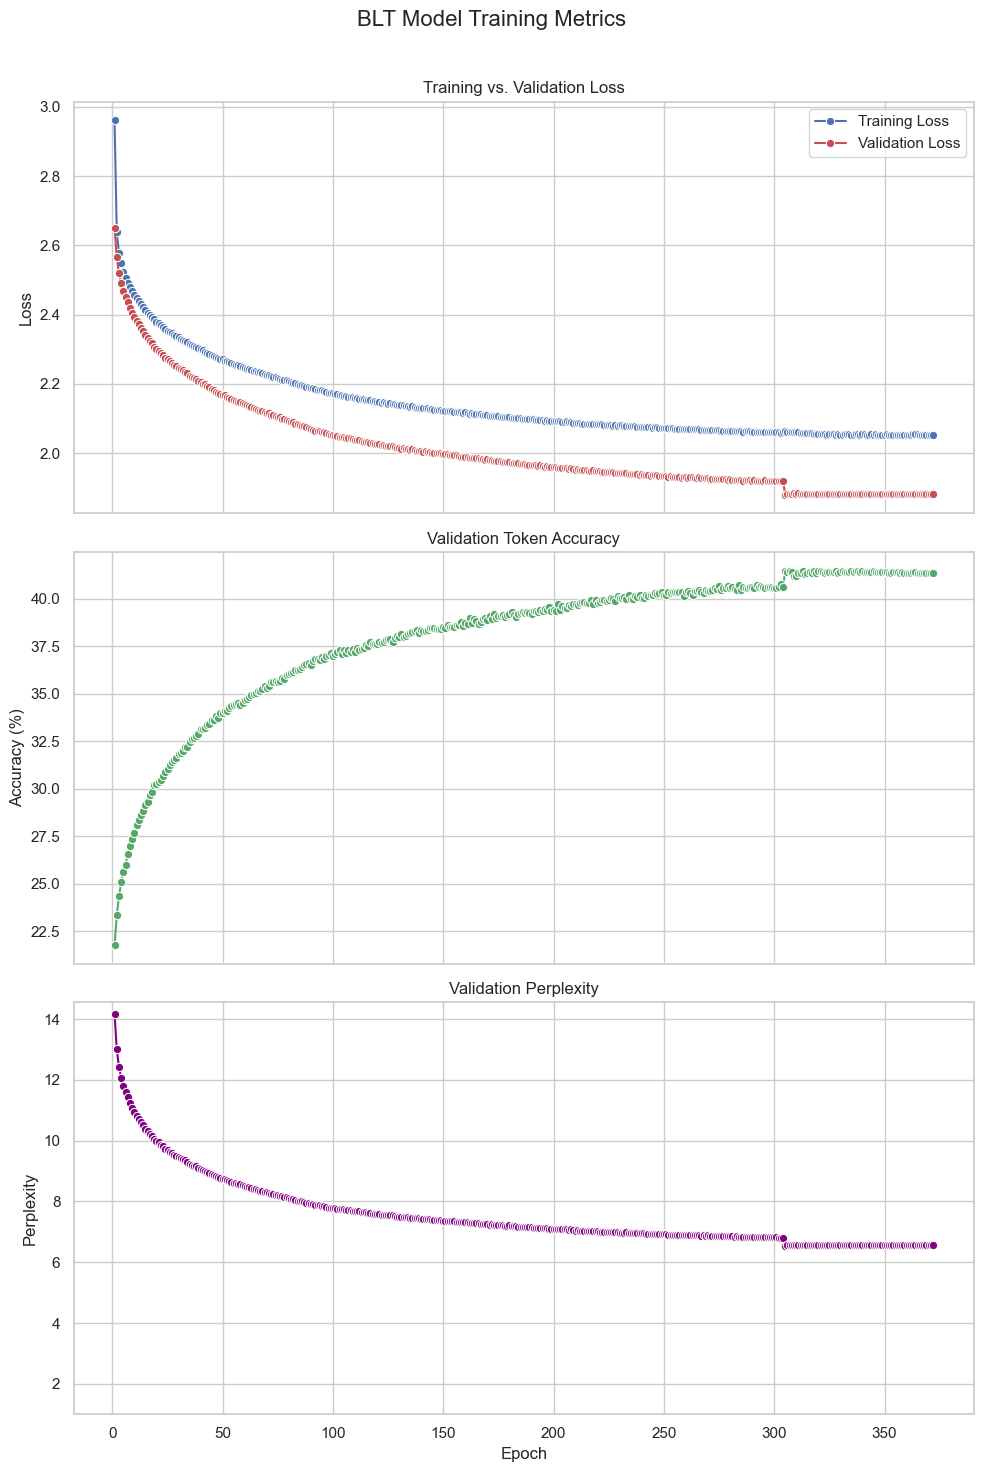

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- User Configuration ---
# Just change this to the name of your saved log file.
LOG_FILE_PATH = "training_log.txt"

def parse_log_file(file_path):
    """
    Reads the training log file and extracts metrics using regular expressions.
    This is extremely fast as it does not load any models.
    """
    metrics = []
    
    # Regex to find the lines with our metrics
    train_loss_regex = re.compile(r"Epoch (\d+)/\d+ - Train Loss: ([\d.]+)")
    val_metrics_regex = re.compile(r"Validation - Loss: ([\d.]+), Perplexity: ([\d.]+), Token Acc: ([\d.]+)%")

    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"ERROR: The log file was not found at '{file_path}'")
        print("Please save your training output to this file and try again.")
        return pd.DataFrame()

    epoch_data = {}
    for line in lines:
        train_match = train_loss_regex.search(line)
        val_match = val_metrics_regex.search(line)

        if train_match:
            # When we find a new training loss, we start a new record
            if epoch_data: # Save the previous epoch's complete data
                metrics.append(epoch_data)
            epoch_data = {
                "epoch": int(train_match.group(1)),
                "train_loss": float(train_match.group(2))
            }
        
        if val_match and epoch_data:
            # Add validation metrics to the current epoch's record
            epoch_data["val_loss"] = float(val_match.group(1))
            epoch_data["val_perplexity"] = float(val_match.group(2))
            epoch_data["val_accuracy"] = float(val_match.group(3))

    if epoch_data: # Append the last record
        metrics.append(epoch_data)
        
    return pd.DataFrame(metrics)

# --- Main Execution ---
if __name__ == '__main__':
    # 1. Parse the log file to get the metrics DataFrame
    metrics_df = parse_log_file(LOG_FILE_PATH)

    if metrics_df.empty:
        print("Could not extract any data. Please check the log file content and path.")
    else:
        print("--- Successfully Parsed Metrics ---")
        print(metrics_df.head())

        # 2. Plotting the results
        sns.set_theme(style="whitegrid")
        fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
        fig.suptitle('BLT Model Training Metrics', fontsize=16)

        # Plot 1: Training vs. Validation Loss
        sns.lineplot(data=metrics_df, x='epoch', y='train_loss', ax=axes[0], label='Training Loss', color='b', marker='o')
        sns.lineplot(data=metrics_df, x='epoch', y='val_loss', ax=axes[0], label='Validation Loss', color='r', marker='o')
        axes[0].set_title('Training vs. Validation Loss')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        # Plot 2: Validation Token Accuracy
        sns.lineplot(data=metrics_df, x='epoch', y='val_accuracy', ax=axes[1], color='g', marker='o')
        axes[1].set_title('Validation Token Accuracy')
        axes[1].set_ylabel('Accuracy (%)')

        # Plot 3: Validation Perplexity
        sns.lineplot(data=metrics_df, x='epoch', y='val_perplexity', ax=axes[2], color='purple', marker='o')
        axes[2].set_title('Validation Perplexity')
        axes[2].set_ylabel('Perplexity')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylim(bottom=1) # Perplexity is meaningless below 1

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        # Save the figure to a file
        plt.savefig("training_metrics_plot.png")
        print("\n✅ Graphs saved to 'training_metrics_plot.png'")
        plt.show()

## Inference Function (Text-to-Text Generation)

In [ ]:
import torch
import torch.nn as nn

# --- Step 1: Define necessary components and vocabulary ---
# This should be consistent with your training script.

# Assume your helper functions (patchify) and model classes (BLTModel) are defined or imported.
# Assume your vocabulary constants are also defined. For clarity, here they are again:
PRINTABLE_ASCII = [chr(i) for i in range(32, 127)]
VOCAB = ['<PAD>', '<SOS>', '<EOS>'] + PRINTABLE_ASCII
CHAR_TO_IDX = {ch: i for i, ch in enumerate(VOCAB)}
IDX_TO_CHAR = {i: ch for i, ch in enumerate(VOCAB)}
PAD_IDX = CHAR_TO_IDX['<PAD>']
SOS_IDX = CHAR_TO_IDX['<SOS>']
EOS_IDX = CHAR_TO_IDX['<EOS>']


# --- Step 2: The Corrected Generation Function ---

@torch.no_grad()
def generate_prediction(model, input_text, max_len=100, device=None):
    """
    Generates a text-to-text prediction using the complete BLTModel.
    """
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.eval()
    model.to(device)

    # 1. Prepare the input: The model expects a BATCH of patch lists.
    #    For a single prediction, we create a batch of size 1.
    patches = patchify(input_text)
    src_patches_batch = [patches] # e.g., [['patch1', 'patch2']]

    # 2. Start the decoding process with the Start-Of-Sequence token.
    output_ids = [SOS_IDX]

    # 3. Autoregressively generate the output sequence one token at a time.
    for _ in range(max_len):
        # Prepare the current sequence as the decoder's input
        tgt_inp = torch.tensor([output_ids], dtype=torch.long, device=device)
        tgt_pad_mask = (tgt_inp == PAD_IDX)

        # >>> THE CRITICAL STEP <<<
        # Call the full model. It will handle the patch embedding, encoder,
        # global transformer, and decoder internally.
        logits = model(src_patches_batch, tgt_inp, tgt_pad_mask)
        
        # 4. Get the next token using greedy decoding (picking the most likely one).
        next_id = logits[:, -1, :].argmax().item()
        
        # 5. Append the new token and check if we should stop.
        output_ids.append(next_id)
        if next_id == EOS_IDX:
            break
            
    # 6. Convert the final list of token IDs back to a string.
    #    We skip the first token, which is the <SOS> token.
    output_text = "".join([IDX_TO_CHAR.get(i, "") for i in output_ids[1:] if i != EOS_IDX])
    
    return output_text


# --- Step 3: Example Usage ---

if __name__ == '__main__':
    # --- Load your final, trained model ---
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Instantiate the model with the correct vocab size
    model = BLTModel(vocab_size=len(VOCAB), d_model=64, nhead=4)
    
    # Load the checkpoint
    ckpt_path = "checkpoints/blt_epoch372.pt" # IMPORTANT: Use your final checkpoint
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")

    # --- Run Prediction ---
    input_text = "reconciliation trolls realized scene"
    output_text = generate_prediction(model, input_text, max_len=100, device=device)
    
    print("\n--- Inference Result ---")
    print(f"Input:  '{input_text}'")
    print(f"Output: '{output_text}'")
    print(f"Expected: '{input_text[::-1]}'")

✅ Loaded checkpoint from epoch 372


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



--- Inference Result ---
Input:  'reconciliation trolls realized scene'
Output: 'seillic noitaretni selbart detaroc seillic'
Expected: 'enecs dezilaer sllort noitailicnocer'


## Prediction on test data and saving CSV

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# --- Step 1: Define ALL necessary components from your training script ---
# This makes the script runnable on its own.
# You MUST paste your final, corrected versions of the following:
#
# 1. All helper functions (patchify, etc.)
# 2. All vocabulary constants (VOCAB, CHAR_TO_IDX, IDX_TO_CHAR, PAD_IDX, SOS_IDX, EOS_IDX)
# 3. The BLTDataset class
# 4. The blt_collate_fn function
# 5. The PatchEmbedder, PositionalEncoding, and BLTModel classes

# --- Step 2: A Batch-Oriented Generation Function (Much Faster) ---

@torch.no_grad()
def generate_batch_predictions(model, data_loader, max_len=100, device=None):
    """
    Generates predictions for an entire DataLoader in batches for efficiency.
    """
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    model.eval()
    model.to(device)
    
    all_predictions = []
    progress_bar = tqdm(data_loader, desc="🚀 Generating Predictions")

    for src_patches_batch, _ in progress_bar:
        batch_size = len(src_patches_batch)
        
        # Start the decoding process for the whole batch with the SOS token
        output_ids = torch.full((batch_size, 1), SOS_IDX, dtype=torch.long, device=device)

        # A flag to track which sequences in the batch are finished
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for _ in range(max_len):
            tgt_pad_mask = (output_ids == PAD_IDX)
            
            # Call the model once for the entire batch
            logits = model(src_patches_batch, output_ids, tgt_pad_mask)
            
            # Get the next token for every sequence in the batch
            next_ids = logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
            
            # Append the new tokens to the sequences
            output_ids = torch.cat([output_ids, next_ids], dim=1)
            
            # Update the 'finished' status for any sequence that just generated an EOS token
            finished = finished | (next_ids.squeeze() == EOS_IDX)
            
            # If all sequences in the batch are finished, we can stop early
            if finished.all():
                break
        
        # Decode the generated ID sequences into text
        for i in range(batch_size):
            # Filter out special tokens
            filtered_ids = [idx for idx in output_ids[i].tolist() if idx not in {SOS_IDX, EOS_IDX, PAD_IDX}]
            pred_text = "".join([IDX_TO_CHAR.get(idx, "") for idx in filtered_ids])
            all_predictions.append(pred_text)
            
    return all_predictions

# --- Step 3: Main Execution Block ---
if __name__ == '__main__':
    # --- Configuration ---
    CHECKPOINT_PATH = "checkpoints/blt_epoch372.pt" # The final model to use
    BATCH_SIZE = 16 # Much faster than batch_size=1
    
    # Setup device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    if device.type == "mps":
        torch.set_float32_matmul_precision("high")

    # --- Load Model ---
    model = BLTModel(vocab_size=len(VOCAB), d_model=64, nhead=4)
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")

    # --- Load Test Data ---
    test_df = pd.read_csv("./../data/test.csv")
    test_ds = BLTDataset(csv_path="./../data/test.csv")
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=blt_collate_fn
    )

    # --- Generate All Predictions ---
    predictions = generate_batch_predictions(model, test_loader, max_len=150, device=device)

    # --- Save Predictions in the Correct Format ---
    # As per the assignment, the output file should have 'input' and 'output' columns.
    output_df = pd.DataFrame({
        'input': test_df['input'],
        'output': predictions
    })
    
    os.makedirs("predictions", exist_ok=True)
    output_path = "predictions/predictions_BLT.csv"
    output_df.to_csv(output_path, index=False)
    
    print(f"\n✅ Predictions saved to {output_path}")
    print("\n--- Prediction Preview ---")
    print(output_df.head().to_string())

✅ Loaded checkpoint from epoch 372


🚀 Generating Predictions:   0%|          | 0/125 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



✅ Predictions saved to predictions/predictions_BLT.csv

--- Prediction Preview ---
                                                                                                             input                                                                                                                   output
0                                                        intimidated campaigns emerging marines spin bel cleansing                                                               gninim seiram gnitalp seirap seiram gnidnep seiram gnitalp
1                                                                          salary lebanese wifi fury fab sta polly                                                                         selbat selbat elbat seilab seilam seillob seilat
2                                                               financing ahmed sexual cinematic puff malibu peach                                                          ecnalpmi ecnah evitalp ecnam ecnalp 

# Character level Model & Training

In [ ]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, falling back to CPU")

✅ Using MPS (Apple Silicon GPU)


## Data & Tokenizer

1. Loads your train.csv and test.csv.
2. Creates a character vocabulary:
    - [PAD], [SOS], [EOS] + printable ASCII chars.
    - Maps chars ↔ IDs (stoi, itos).
3. Provides encode/decode functions.
4. Tests it on a sample string.

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import string

# --- Step 1: Load Data ---
train_df = pd.read_csv("./../data/train.csv")
test_df  = pd.read_csv("./../data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())

# --- Step 2: Character Tokenizer ---
# Printable ASCII characters 32–126
ascii_chars = [chr(i) for i in range(32, 127)]
special_tokens = ["[PAD]", "[SOS]", "[EOS]"]

itos = special_tokens + ascii_chars   # id → char
stoi = {ch: i for i, ch in enumerate(itos)}  # char → id

PAD_IDX = stoi["[PAD]"]
SOS_IDX = stoi["[SOS]"]
EOS_IDX = stoi["[EOS]"]

vocab_size = len(itos)

print("\nVocab size:", vocab_size)
print("PAD idx:", PAD_IDX, "SOS idx:", SOS_IDX, "EOS idx:", EOS_IDX)

# --- Encode / Decode functions ---
def encode_text(text, add_special=True):
    ids = [stoi[ch] for ch in text if ch in stoi]
    if add_special:
        ids = [SOS_IDX] + ids + [EOS_IDX]
    return torch.tensor(ids, dtype=torch.long)

def decode_ids(ids):
    chars = []
    for i in ids:
        if i == PAD_IDX or i == SOS_IDX or i == EOS_IDX:
            continue
        chars.append(itos[i])
    return "".join(chars)

# --- Quick test ---
sample = "LMA is fun!"
encoded = encode_text(sample)
decoded = decode_ids(encoded.tolist())

print("Sample:", sample)
print("Encoded:", encoded.tolist())
print("Decoded:", decoded)

Train shape: (10000, 2)
Test shape: (2000, 2)
                                               input  \
0               reconciliation trolls realized scene   
1                        scratched kemp blah devices   
2  delusional engineered perfect prey englishman ...   
3  boomers nfl reacts parallels everything 6 redu...   
4  patience put christmas superhero luc rake fulf...   

                                              target  
0               enecs dezilaer sllort noitailicnocer  
1                        secived halb pmek dehctarcs  
2  hctarcs detsub namhsilgne yerp tcefrep dereeni...  
3  stcudnoc ysereh redlof secuder 6 gnihtyreve sl...  
4  ylesned ylno elbats latnenitnoc dellifluf ekar...  

Vocab size: 98
PAD idx: 0 SOS idx: 1 EOS idx: 2
Sample: LMA is fun!
Encoded: [1, 47, 48, 36, 3, 76, 86, 3, 73, 88, 81, 4, 2]
Decoded: LMA is fun!


## Dataset + Collate

- CharDataset → loads strings, encodes them into token IDs.
- collate_fn → pads sequences per batch + stores lengths.
- DataLoader → provides batches for training & testing.
- Prints shapes and a decoded sample to check correctness.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# --- Dataset Class ---
class CharDataset(Dataset):
    def __init__(self, df):
        self.inputs = df["input"].tolist()
        self.targets = df["target"].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        src_text = self.inputs[idx]
        tgt_text = self.targets[idx]

        src_ids = encode_text(src_text, add_special=True)  # [SOS] ... [EOS]
        tgt_ids = encode_text(tgt_text, add_special=True)

        return src_ids, tgt_ids


# --- Collate Function ---
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    # Pad sequences
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)

    # Lengths (before padding)
    src_lengths = torch.tensor([len(x) for x in src_batch], dtype=torch.long)
    tgt_lengths = torch.tensor([len(x) for x in tgt_batch], dtype=torch.long)

    return src_padded, src_lengths, tgt_padded, tgt_lengths


# --- Create Dataset + DataLoader ---
train_ds = CharDataset(train_df)
test_ds = CharDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

import pandas as pd
from sklearn.model_selection import train_test_split

test_df = pd.read_csv("./../data/test.csv")  # original test dataset
val_df, holdout_df = train_test_split(test_df, test_size=0.5, random_state=42)

val_ds = CharDataset(val_df)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# --- Quick Check ---
src_padded, src_lengths, tgt_padded, tgt_lengths = next(iter(train_loader))

print("src_padded shape:", src_padded.shape)
print("tgt_padded shape:", tgt_padded.shape)
print("\nsrc_lengths:", src_lengths[:5])
print("tgt_lengths:", tgt_lengths[:5])
print("\nExample decoded input:", decode_ids(src_padded[0].tolist()))
print("Example decoded target:", decode_ids(tgt_padded[0].tolist()))

src_padded shape: torch.Size([32, 132])
tgt_padded shape: torch.Size([32, 132])

src_lengths: tensor([67, 21, 80, 38, 67])
tgt_lengths: tensor([67, 21, 80, 38, 67])

Example decoded input: cam environments eventual fallen aug merchant garry quebec latter
Example decoded target: rettal cebeuq yrrag tnahcrem gua nellaf lautneve stnemnorivne mac


In [ ]:
# --- Character Vocabulary (printable ASCII + special tokens) ---
import string

PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2

# Printable ASCII characters (32-126)
chars = [chr(i) for i in range(32, 127)]
VOCAB = {c: i+3 for i, c in enumerate(chars)}  # reserve 0,1,2 for PAD, SOS, EOS
INV_VOCAB = {i: c for c, i in VOCAB.items()}

VOCAB_SIZE = len(VOCAB) + 3  # include PAD, SOS, EOS
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 98


## Baseline Model

- Embedding layer for characters
- Positional encoding
- Transformer encoder–decoder (2 layers each)
- Linear projection to vocab size

In [ ]:
import math
import torch
import torch.nn as nn

# --- Positional Encoding (sinusoidal) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, L, D]
        x = x + self.pe[:, :x.size(1), :]
        return x


# --- Baseline Transformer Model ---
class CharTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, num_layers=2, dim_ff=128, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Embeddings
        self.src_embed = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.tgt_embed = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)

        self.pos_encoder = PositionalEncoding(d_model)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                    dim_feedforward=dim_ff, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, enable_nested_tensor=False)

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                    dim_feedforward=dim_ff, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output projection
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt_inp):
        """
        src: [B, Ls]
        tgt_inp: [B, Lt]
        """
        # Embedding + positional encoding
        src_emb = self.pos_encoder(self.src_embed(src))  # [B, Ls, D]
        tgt_emb = self.pos_encoder(self.tgt_embed(tgt_inp))  # [B, Lt, D]

        # Masks
        src_key_padding_mask = (src == PAD_IDX)  # [B, Ls]
        tgt_key_padding_mask = (tgt_inp == PAD_IDX)  # [B, Lt]
        causal_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(src.device)

        # Encode
        memory = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)

        # Decode
        out = self.decoder(tgt=tgt_emb, memory=memory,
                            tgt_mask=causal_mask,
                            tgt_key_padding_mask=tgt_key_padding_mask,
                            memory_key_padding_mask=src_key_padding_mask)

        # Project to vocab
        logits = self.fc_out(out)  # [B, Lt, vocab_size]
        return logits

In [ ]:
# Create model
baseline_model = CharTransformer(vocab_size=len(VOCAB), d_model=64, nhead=4, num_layers=2).to(device)

# Dummy batch
src_padded, src_lengths, tgt_padded, tgt_lengths = next(iter(train_loader))

# Teacher forcing: shift target
tgt_inp = tgt_padded[:, :-1]
tgt_out = tgt_padded[:, 1:]

# Forward pass
logits = baseline_model(src_padded.to(device), tgt_inp.to(device))

print("Logits shape:", logits.shape)  # [B, Lt-1, vocab_size]

Logits shape: torch.Size([32, 117, 95])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


## Training

- AdamW optimizer
- CrossEntropyLoss with ignore_index=PAD_IDX
- Gradient clipping
- Checkpoint saving every few epochs
- Optional resume from checkpoint

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.nn.utils import clip_grad_norm_

# ----------------------------
# Training loop for baseline Transformer
# ----------------------------
def train_baseline(
    model,
    train_loader,
    val_loader=None,   # optional validation loader
    num_epochs=1000,
    lr=1e-3,
    device=None,
    save_every=5,
    val_every=50,
    resume_path=None
):
    # --- Pick device automatically if not provided ---
    if device is None:
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    print(f"Training on: {device}")

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)  # ignore <PAD> tokens

    os.makedirs("checkpoints_baseline", exist_ok=True)

    # --- Resume from checkpoint ---
    start_epoch = 1
    if resume_path and os.path.exists(resume_path):
        print(f"🔄 Resuming from checkpoint: {resume_path}")
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"✅ Resumed from epoch {checkpoint['epoch']} (loss {checkpoint['loss']:.4f})")

    # --- Training loop ---
    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            src, src_lengths, tgt, tgt_lengths = batch
            src, tgt = src.to(device), tgt.to(device)

            tgt_inp = tgt[:, :-1]   # decoder input
            tgt_out = tgt[:, 1:]    # expected output

            logits = model(src, tgt_inp)

            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_out.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        
        # --- Validation ---
        if val_loader is not None:
            val_loss, val_acc = evaluate_baseline(model, val_loader, criterion, device)
            val_perplexity = math.exp(val_loss)
            print(f"📘 Epoch {epoch}/{num_epochs} - Train Loss: {avg_loss:.4f}")
            print(f"📗 Validation - Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.2f}, Token Acc: {val_acc:.2f}%")
        else:
            print(f"📘 Epoch {epoch}/{num_epochs} - Train Loss: {avg_loss:.4f}")

        # --- Save checkpoint ---
        if epoch % save_every == 0 or epoch == num_epochs:
            ckpt_path = f"checkpoints_baseline/char_transformer_epoch{epoch}.pt"
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "loss": avg_loss
            }, ckpt_path)
            print(f"✅ Saved checkpoint: {ckpt_path}")


# ----------------------------
# Evaluation / Validation
# ----------------------------
@torch.no_grad()
def evaluate_baseline(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    for batch in val_loader:
        src, src_lengths, tgt, tgt_lengths = batch
        src, tgt = src.to(device), tgt.to(device)

        tgt_inp = tgt[:, :-1]
        tgt_out = tgt[:, 1:]

        logits = model(src, tgt_inp)

        # Compute loss
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_out.reshape(-1)
        )
        total_loss += loss.item()

        # Accuracy (ignore PAD)
        preds = logits.argmax(dim=-1)
        mask = tgt_out != PAD_IDX
        correct_tokens += ((preds == tgt_out) & mask).sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100.0 * correct_tokens / total_tokens
    return avg_loss, accuracy

In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

device = torch.device("mps")
train_baseline(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=1000,
    lr=1e-3,
    device=device,
    save_every=10,
    resume_path="checkpoints_baseline/char_transformer_epoch500.pt"
)

Training on: mps
🔄 Resuming from checkpoint: checkpoints_baseline/char_transformer_epoch470.pt
✅ Resumed from epoch 470 (loss 0.0057)
📘 Epoch 471/1000 - Train Loss: 0.0056
📗 Validation - Loss: 0.0004, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 472/1000 - Train Loss: 0.0062
📗 Validation - Loss: 0.0004, Perplexity: 1.00, Token Acc: 99.95%
📘 Epoch 473/1000 - Train Loss: 0.0062
📗 Validation - Loss: 0.0006, Perplexity: 1.00, Token Acc: 99.95%
📘 Epoch 474/1000 - Train Loss: 0.0061
📗 Validation - Loss: 0.0003, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 475/1000 - Train Loss: 0.0061
📗 Validation - Loss: 0.0005, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 476/1000 - Train Loss: 0.0054
📗 Validation - Loss: 0.0002, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 477/1000 - Train Loss: 0.0056
📗 Validation - Loss: 0.0004, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 478/1000 - Train Loss: 0.0063
📗 Validation - Loss: 0.0011, Perplexity: 1.00, Token Acc: 99.94%
📘 Epoch 479/1000 - Train Loss: 0.0063
📗 Va

KeyboardInterrupt: 

## Test set prediction

1. encode_text() and decode_text() are the same functions you used for your baseline dataset.
2. SOS_IDX and EOS_IDX should be your special token indices (start/end).
3. This uses greedy decoding only. No beam search or sampling needed.
4. You can now submit predictions_normal.csv for evaluation.

Load Model and Define Helpers

In [ ]:
import torch

# Force CPU
device = torch.device("cpu")

# Load checkpoint on CPU
checkpoint_path = "checkpoints_baseline/char_transformer_epoch500.pt"
baseline_model.load_state_dict(torch.load(checkpoint_path, map_location=device)["model_state"])
baseline_model.to(device)
baseline_model.eval()

# Vocabulary
vocab = {c:i+3 for i,c in enumerate([chr(i) for i in range(32,127)])}
inv_vocab = {i:c for c,i in vocab.items()}
PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2

def encode_text(text):
    return [SOS_IDX] + [vocab[c] for c in text] + [EOS_IDX]

def decode_text(ids):
    return "".join([inv_vocab[i] for i in ids if i > 2])

# Autoregressive prediction
def generate_single_char_model(text, model, max_len=128):
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor([encode_text(text)], dtype=torch.long, device=device)
        output_ids = [SOS_IDX]

        for t in range(max_len):
            tgt_ids = torch.tensor([output_ids], dtype=torch.long, device=device)
            logits = model(input_ids, tgt_ids)
            next_id = logits[0, -1].argmax().item()
            output_ids.append(next_id)
            if next_id == EOS_IDX:
                break

        return decode_text(output_ids[1:])

# Example
sample_text = "Enjoy your day having extreme fun!"
prediction = generate_single_char_model(sample_text, baseline_model)
print("Input: ", sample_text)
print("Prediction:", prediction)

Input:  Enjoy your day having extreme fun!
Prediction: !nuf emertxe gnivah yad ruoy yojn


Inference Testing (Single, Interactive Example)

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import math

# --- 1. Setup ---

# Define constants to match the training environment
PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2
VOCAB_SIZE = 95  # FIX: Hardcode the vocab size from the trained model
MAX_LEN = 128    # Define a max generation length

# --- Vocabulary and Helper Functions ---
# Re-create the exact vocabulary used during training
chars = [chr(i) for i in range(32, 127)]
_vocab = {c: i + 3 for i, c in enumerate(chars)}
INV_VOCAB = {i: c for c, i in _vocab.items()}

def encode_text(text, add_special=True):
    # FIX: Use the full version of the function that accepts 'add_special'
    ids = [_vocab.get(ch, -1) for ch in text if ch in _vocab]
    if add_special:
        ids = [SOS_IDX] + ids + [EOS_IDX]
    return torch.tensor(ids, dtype=torch.long)

def decode_ids(ids):
    """Decodes a list of token IDs back to a string."""
    return "".join([INV_VOCAB.get(i, '') for i in ids if i not in {PAD_IDX, SOS_IDX, EOS_IDX}])

# --- Device and Model Loading ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS for inference")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, using CPU for inference")

# Instantiate your model architecture with the CORRECT vocab_size
baseline_model = CharTransformer(vocab_size=VOCAB_SIZE, d_model=64, nhead=4, num_layers=2).to(device)

# Load the saved weights
checkpoint_path = "checkpoints_baseline/char_transformer_epoch500.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
baseline_model.load_state_dict(checkpoint["model_state"])

# Set the model to evaluation mode
baseline_model.eval()
print("✅ Model loaded and set to evaluation mode.")

✅ Using MPS for inference
✅ Model loaded and set to evaluation mode.


In [ ]:
# --- 2. Test Set Prediction ---

@torch.no_grad()
def predict_on_test_set(model, data_loader, device):
    """Generates predictions for an entire test set and returns a DataFrame."""
    model.eval()
    results = []
    
    # FIX: Make the loop more robust by iterating over 'batch'
    for batch in data_loader:
        src_padded = batch[0].to(device)
        tgt_padded = batch[2] # For ground truth comparison

        tgt_inp = torch.full((src_padded.size(0), 1), SOS_IDX, dtype=torch.long, device=device)

        for _ in range(MAX_LEN):
            logits = model(src_padded, tgt_inp)
            next_token = logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
            tgt_inp = torch.cat([tgt_inp, next_token], dim=1)
            if (tgt_inp == EOS_IDX).any(dim=1).all():
                break

        source_texts = [decode_ids(s.tolist()) for s in src_padded]
        target_texts = [decode_ids(t.tolist()) for t in tgt_padded]
        predicted_texts = [decode_ids(p.tolist()) for p in tgt_inp]
        
        for i in range(len(source_texts)):
            results.append({
                "input": source_texts[i],
                "ground_truth": target_texts[i],
                "prediction": predicted_texts[i]
            })

    return pd.DataFrame(results)

print("\n🔍 Generating predictions on the test set...")
predictions_df = predict_on_test_set(baseline_model, test_loader, device)
print("✅ Predictions generated. Here are the first 10 examples:")
print(predictions_df.head(10).to_string())


🔍 Generating predictions on the test set...
✅ Predictions generated. Here are the first 10 examples:
                                                                                                             input                                                                                                     ground_truth                                                                                                             prediction
0                                                        intimidated campaigns emerging marines spin bel cleansing                                                        gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni      gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni snaelc leb nips seniram gnignigreme sngiapmac detimitni
1                                                                          salary lebanese wifi fury fab sta polly                                                                          yllop ats baf yr

In [ ]:
# --- 3. Inference Testing ---

def generate_prediction(input_text, model, device):
    """Generates a prediction for a single input string."""
    model.eval()
    with torch.no_grad():
        # This function now works because encode_text is defined correctly above
        src_tensor = encode_text(input_text, add_special=True).unsqueeze(0).to(device)
        output_ids = [SOS_IDX]

        for _ in range(MAX_LEN):
            tgt_tensor = torch.tensor(output_ids, dtype=torch.long, device=device).unsqueeze(0)
            logits = model(src_tensor, tgt_tensor)
            next_id = logits[0, -1].argmax().item()
            output_ids.append(next_id)
            if next_id == EOS_IDX:
                break
        
        return decode_ids(output_ids)

print("\n🤖 Running interactive inference tests...")

sample1 = "hello world"
pred1 = generate_prediction(sample1, baseline_model, device)
print(f"\nInput:      '{sample1}'")
print(f"Prediction: '{pred1}'")

sample2 = "PyTorch is great for building transformers."
pred2 = generate_prediction(sample2, baseline_model, device)
print(f"\nInput:      '{sample2}'")
print(f"Prediction: '{pred2}'")


🤖 Running interactive inference tests...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



Input:      'hello world'
Prediction: 'dlrow olleh'

Input:      'PyTorch is great for building transformers.'
Prediction: '.sremrofsnart gnidliub rof taerg si hcroyy'


## Saving predictions

In [ ]:
import torch
import pandas as pd
import os
from tqdm.auto import tqdm

# --- 1. Setup (Model, Constants, and Helpers) ---
# Ensure this setup matches the environment you used for training and previous testing.

# Define constants
PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2
VOCAB_SIZE = 95
MAX_LEN = 128

# Vocabulary and Helper Functions
chars = [chr(i) for i in range(32, 127)]
_vocab = {c: i + 3 for i, c in enumerate(chars)}
INV_VOCAB = {i: c for c, i in _vocab.items()}

def encode_text(text, add_special=True):
    ids = [_vocab.get(ch, -1) for ch in text if ch in _vocab]
    if add_special:
        ids = [SOS_IDX] + ids + [EOS_IDX]
    return torch.tensor(ids, dtype=torch.long)

def decode_ids(ids):
    return "".join([INV_VOCAB.get(i, '') for i in ids if i not in {PAD_IDX, SOS_IDX, EOS_IDX}])

# Device and Model Loading
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"✅ Using {device} for inference")

# Instantiate your model architecture
# This needs the CharTransformer class definition from your original script
baseline_model = CharTransformer(vocab_size=VOCAB_SIZE, d_model=64, nhead=4, num_layers=2).to(device)

# Load the saved weights
checkpoint_path = "checkpoints_baseline/char_transformer_epoch500.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
baseline_model.load_state_dict(checkpoint["model_state"])
baseline_model.eval()
print("✅ Model loaded successfully.")


# --- 2. Single Prediction Function ---

def generate_prediction(input_text, model, device):
    """Generates a prediction for a single input string."""
    model.eval()
    with torch.no_grad():
        src_tensor = encode_text(input_text, add_special=True).unsqueeze(0).to(device)
        output_ids = [SOS_IDX]

        for _ in range(MAX_LEN):
            tgt_tensor = torch.tensor(output_ids, dtype=torch.long, device=device).unsqueeze(0)
            logits = model(src_tensor, tgt_tensor)
            next_id = logits[0, -1].argmax().item()
            output_ids.append(next_id)
            if next_id == EOS_IDX:
                break
        
        return decode_ids(output_ids)


# --- 3. Main Script to Process CSV ---

# Define file paths
input_csv_path = "./../data/test.csv"
output_dir = "./predictions"
output_csv_path = os.path.join(output_dir, "test_predictions.csv")

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the test data
print(f"\nReading data from {input_csv_path}...")
df = pd.read_csv(input_csv_path)

# Initialize a list to store predictions
predictions_list = []

print("Generating predictions for each row...")
# Use tqdm to create a progress bar
for input_text in tqdm(df['input'], desc="➡️ Processing rows"):
    # Generate a prediction for the current input text
    prediction = generate_prediction(input_text, baseline_model, device)
    # Add the prediction to our list
    predictions_list.append(prediction)

# Add the list of predictions as a new column in the DataFrame
df['predictions'] = predictions_list

# Save the updated DataFrame to a new CSV file
df.to_csv(output_csv_path, index=False)

print(f"\n🎉 Success! Predictions saved to: {output_csv_path}")
print("\nHere's a preview of the final data:")
print(df.head().to_string())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Using mps for inference
✅ Model loaded successfully.

Reading data from ./../data/test.csv...
Generating predictions for each row...


➡️ Processing rows:   0%|          | 0/2000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
➡️ Processing rows: 100%|██████████| 2000/2000 [15:35<00:00,  2.14it/s]



🎉 Success! Predictions saved to: ./predictions/test_predictions.csv

Here's a preview of the final data:
                                                                                                             input                                                                                                           target                                                                                                      predictions
0                                                        intimidated campaigns emerging marines spin bel cleansing                                                        gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni                                                        gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni
1                                                                          salary lebanese wifi fury fab sta polly                                                                          yllop ats baf yruf ifiw 

# Evaluation & Predictions

##  Metrics evaluation script for both BLT and baseline models

1.	Token-level accuracy
2.	Average sequence length (input tokens vs predicted tokens)

In [ ]:
import pandas as pd

def evaluate_predictions(pred_csv_path, original_csv_path, prediction_col_name="output"): # <-- Added argument with default
    """
    Evaluates predictions against a target file.
    
    Args:
        pred_csv_path (str): Path to the CSV containing predictions.
        original_csv_path (str): Path to the original test CSV with targets.
        prediction_col_name (str): The name of the column containing predictions in pred_csv_path.
    """
    try:
        df_pred = pd.read_csv(pred_csv_path)
    except FileNotFoundError:
        print(f"❌ ERROR: Prediction file not found at {pred_csv_path}")
        return float('nan'), float('nan'), float('nan') # Return NaN if file missing
        
    df_orig = pd.read_csv(original_csv_path)

    # --- Check if the prediction column exists ---
    if prediction_col_name not in df_pred.columns:
        print(f"❌ ERROR: Column '{prediction_col_name}' not found in {pred_csv_path}.")
        print(f"   Available columns are: {list(df_pred.columns)}")
        return float('nan'), float('nan'), float('nan') # Return NaN if column missing

    total_tokens = 0
    correct_tokens = 0
    total_input_len = 0
    total_output_len = 0

    # Ensure dataframes have the same length
    if len(df_pred) != len(df_orig):
        print(f"⚠️ WARNING: Prediction file ({len(df_pred)} rows) and original file ({len(df_orig)} rows) have different lengths. Evaluating common rows.")
    
    num_rows_to_evaluate = min(len(df_pred), len(df_orig))

    for idx in range(num_rows_to_evaluate):
        # --- FIX 1: Use the specified prediction column name ---
        pred = str(df_pred.loc[idx, prediction_col_name]) 
        # ---------------------------------------------------
        
        target = str(df_orig.loc[idx, "target"])
        input_str = str(df_orig.loc[idx, "input"])

        # Token-level comparison
        min_len = min(len(pred), len(target))
        correct_tokens += sum([pred[i] == target[i] for i in range(min_len)])
        total_tokens += len(target)

        # Sequence length stats
        total_input_len += len(input_str)
        total_output_len += len(pred)

    token_accuracy = 100.0 * correct_tokens / total_tokens if total_tokens > 0 else 0
    avg_input_len = total_input_len / num_rows_to_evaluate if num_rows_to_evaluate > 0 else 0
    avg_output_len = total_output_len / num_rows_to_evaluate if num_rows_to_evaluate > 0 else 0

    print(f"✅ Evaluation for {pred_csv_path}")
    print(f"Token-level Accuracy: {token_accuracy:.2f}%")
    print(f"Average input length: {avg_input_len:.2f} chars")
    print(f"Average predicted output length: {avg_output_len:.2f} chars") 
    print("-" * 50)
    return token_accuracy, avg_input_len, avg_output_len

# --- Evaluate BLT predictions ---
# Assuming your BLT prediction file correctly uses the 'output' column
blt_acc, blt_in_len, blt_out_len = evaluate_predictions(
    "./predictions/predictions_BLT.csv", "./../data/test.csv"
)

# --- Evaluate Baseline predictions ---
# FIX 2: Correctly assign results to baseline variables
# IMPORTANT: Check your baseline CSV ('test_predictions.csv'). If the prediction
# column is named something else (e.g., 'prediction'), change it below.
baseline_acc, base_in_len, base_out_len = evaluate_predictions(
    "./predictions/test_predictions.csv", 
    "./../data/test.csv",
    prediction_col_name="predictions"
)

# --- Comparison Summary ---
print("📊 Comparison Summary:")
print(f"BLT      | Acc: {blt_acc:.2f}%, Avg Input: {blt_in_len:.2f}, Avg Pred: {blt_out_len:.2f}")
print(f"Baseline | Acc: {baseline_acc:.2f}%, Avg Input: {base_in_len:.2f}, Avg Pred: {base_out_len:.2f}")

✅ Evaluation for ./predictions/predictions_BLT.csv
Token-level Accuracy: 8.39%
Average input length: 70.85 chars
Average predicted output length: 78.03 chars
--------------------------------------------------
✅ Evaluation for ./predictions/test_predictions.csv
Token-level Accuracy: 97.77%
Average input length: 70.85 chars
Average predicted output length: 70.78 chars
--------------------------------------------------
📊 Comparison Summary:
BLT      | Acc: 8.39%, Avg Input: 70.85, Avg Pred: 78.03
Baseline | Acc: 97.77%, Avg Input: 70.85, Avg Pred: 70.78
